In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt, cm as cm, colors as colors, __version__ as mplver
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from glob import glob
from astropy.timeseries import LombScargle
from astropy.table import Table
from astropy import __version__ as apver
from astropy import units as u, constants as c
from scipy import stats, __version__ as spver
import warnings
from TESStools import *
from tqdm.notebook import tqdm
from matplotlib import lines as mlines
from matplotlib.colors import Normalize
from scipy.stats import sigmaclip
import h5py as h5

In [2]:
print(np.__version__,pd.__version__,mplver,apver,spver)

1.20.3 1.3.0 3.3.4 4.2.1 1.6.2


In [3]:
#We're going to need our stars...
cool_sgs = pd.read_csv('../OutputFiles/sample.csv',index_col=0)
#merged with SLFV and prewhitening info...
slfv_params = pd.read_csv('../OutputFiles/slfv_params.csv',index_col=0)
inspected = pd.read_csv('../OutputFiles/prewhitening.csv',index_col=0)
merged = pd.merge(cool_sgs,slfv_params,left_index=True,right_index=True)
merged = pd.merge(merged,inspected,left_index=True,right_index=True)

# Now we're going to look for pulsators. First, grab stars where we can extract a frequency with >5 sigma

# Grab stars where we can extract a frequency with >5 sigma
pulse_detected = merged[(merged['n_peaks'] > 0) & (merged['highest_amp']/merged['highest_amp_error'] > 5)]
print(f"{len(pulse_detected)} stars with 5-sigma frequencies out of {len(merged)} total")

# We also used a GP to see if these frequencies were significant above the SLFV
gp_pulse = pd.read_csv('../OutputFiles/Find_FYPS_GP_results.csv', index_col=0)
pulse_detected_gp = pd.merge(pulse_detected, gp_pulse, left_index=True, right_index=True)
print(f"GP reveals {len(pulse_detected_gp[pulse_detected_gp['pulse_GP']==True])} true periodic stars")

# Load in info on which stars are consistent with RR Lyrae and Beta Cepheids...
likely_rrcep = pd.read_csv('../OutputFiles/likelyRRCep.csv',index_col=0)
likely_bcep = pd.read_csv('../OutputFiles/likelyBCep.csv',index_col=0)
contaminants = pd.merge(likely_rrcep,likely_bcep,left_index=True,right_index=True)

new = pd.merge(pulse_detected_gp,contaminants,left_index=True,right_index=True)
pulse_clean = new[(new['pulse_GP'])&(~new['LikelyRR'])&(~new['LikelyCep'])&(~new['LikelyBCep'])]
print(f"Filtering out contaminants leaves us with {len(pulse_clean)} stars")

155 stars with 5-sigma frequencies out of 201 total
GP reveals 154 true periodic stars
Filtering out contaminants leaves us with 111 stars


In [4]:
#A way to grab FYPS
def fyps_box(df):
    """
    Returns part of dataframe where teff and lum are in the FYPS box
    """
    
    #tmin = df['teff'] >= 3.6
    #tmax = df['teff'] <= 4.1
    #lmax = df['lum'] <= 7.76 - 0.6*df['teff']
    lmin = df['lum'] >= 5.0 #6.23 - 0.3*df['teff']
    
    return lmin # & lmax & tmin & tmax

In [5]:
candidate_fyps = pulse_clean[fyps_box(pulse_clean)]
all_in_box = merged[fyps_box(merged)]
len(candidate_fyps), len(all_in_box), len(candidate_fyps)/len(all_in_box)

(39, 63, 0.6190476190476191)

In [6]:
cf_lmc = candidate_fyps[candidate_fyps['Gal']=='LMC']
cf_smc = candidate_fyps[candidate_fyps['Gal']=='LMC']

In [67]:
mosaic = """
LLL
RRR
RRR
"""

for tic,cf in tqdm(candidate_fyps.iterrows(), total=len(candidate_fyps)):

    fig, ax_dict = plt.subplot_mosaic(mosaic, dpi=300)

    lc, lc_smooth = lc_extract(get_lc_from_id(tic), smooth='10T')
    time, flux, err = lc['Time'], lc['Flux'], lc['Err']
    t_s, f_s = lc_smooth['Time'], lc_smooth['Flux']

    ax_dict['L'].scatter(time, flux, s=1, c='k', rasterized=True)
    ax_dict['L'].plot(t_s, f_s, lw=0.5, c='C2', rasterized=True)
    ax_dict['L'].set(xlim=(time.min(),time.max()),
                     xlabel='Time',
                     ylabel='PDCSAP Flux')

    pseudo_NF = 0.5 / (np.mean(np.diff(time)))
    ls = LombScargle(time,flux,dy=err,)
    freq,power=ls.autopower(normalization='psd',maximum_frequency=pseudo_NF)
    power /= len(time)

    popt = cf[['alpha','tau','gamma','alphaw']].values
    fit = np.power(noise_func(freq,*popt),2.0)

    resid = power/fit

    ax_dict['R'].plot(freq,resid/resid.max(),rasterized=True) 
    
    with h5.File('prewhitening.hdf5', 'r') as f:
        good_fs = f[f'{tic}/good_fs'][()][:,0]
        
    for g in good_fs:
        plt.axvline(x=g, c='k', alpha=0.5, ls='--', zorder=-1)
    
    name = cf['CommonName'].lstrip('V*').replace(r'[',r'{[').replace(r']',r']}')
    if name[0:2] == 'SV':
        name = name.lstrip('SV*')
        
    
    ax_dict['R'].text(8,0.9,f'TIC {tic} \n {name}',rasterized=True)
    ax_dict['R'].set(xlim=(0,10),
                     xlabel='Frequency',
                     ylabel='Normalized Residual Power')

    fig.tight_layout()
    gal = cf['Gal'].lower()
    plt.savefig(f'../plots/app_plots/{gal}_tic{tic}_app.pdf', bbox_inches='tight')
    plt.close(fig)

  0%|          | 0/39 [00:00<?, ?it/s]

In [7]:
lmc_header = r"""\begin{deluxetable*}{lcccccc}
\tabletypesize{\scriptsize}
\tablecaption{Names, TIC numbers, coordinates, \tess magnitudes and positions in the HR diagram of the FYPS identified in the LMC, ordered by effective temperature from coolest to warmest. Typical uncertainties in $\log T_{\rm {eff}}$ and $\log L/L_\odot$ are 0.015 dex and 0.10 dex respectively.\label{tab:lmc_fyps}}
\tablehead{\colhead{Common Name} & \colhead{TIC Number} & \colhead{R.A.} & \colhead{Dec} & \colhead{$T$} & \colhead{$\log T_{\rm{eff}}$} & \colhead{$\log L/L_\odot$}\\
\colhead{} & \colhead{} & \colhead{[deg]} & \colhead{[deg]} & \colhead{[mag]} & \colhead{[K]} & \colhead{$L_\odot$}} 
\startdata
"""

smc_header = r"""\begin{deluxetable*}{lcccccc}
\tabletypesize{\scriptsize}
\tablecaption{Similar to Table \ref{tab:lmc_fyps} for FYPS identified in the SMC.\label{tab:smc_fyps}}
\tablehead{\colhead{Common Name} & \colhead{TIC Number} & \colhead{R.A.} & \colhead{Dec} & \colhead{$T$} & \colhead{$\log T_{\rm{eff}}$} & \colhead{$\log L/L_\odot$}\\
\colhead{} & \colhead{} & \colhead{[deg]} & \colhead{[deg]} & \colhead{[mag]} & \colhead{[K]} & \colhead{$L_\odot$}} 
\startdata
"""

lmc_plots_header = r"""\begin{figure*}[p!]
"""
smc_plots_header = r"""\begin{figure*}[p!]
"""

lmc_i = 0
lmc_num_box = 0
lmc_page_flag = False
smc_i = 0
smc_num_box = 0
smc_page_flag = False

for tic,cf in tqdm(candidate_fyps.iterrows(), total=len(candidate_fyps)):
    
    name = cf['CommonName'].lstrip('V*').replace(r'[',r'{[').replace(r']',r']}')
    if name[0:2] == 'SV':
        name = name.lstrip('SV*')

    gal = cf['Gal'].lower()
    
    # TeX
    if gal == 'lmc':
        if lmc_i % 2 == 0:
            lmc_plots_header += r'\gridline{\fig{'+f'app_plots/{gal}_tic{tic}_app.pdf'+r'}{0.5\textwidth}{}'
        elif lmc_i % 2 == 1:
            lmc_plots_header += r"""
            \fig{"""+f'app_plots/{gal}_tic{tic}_app.pdf'+r"""}{0.5\textwidth}{}}
            """+'\n'
        else:
            print('fucked up mod')
            
        ra = f"{cf['RA']:.8f}"
        dec = f"{cf['Dec']:.8f}"
        tmag = f"{cf['Tmag']:.3f}"
        teff = f"{cf['teff']:.3f}"
        lum = f"{cf['lum']:.3f}"

        entry = list(map(str,[name,tic,ra,dec,tmag,teff,lum]))

        sep = ' & '

        lmc_header += sep.join(entry)
        lmc_header += ' \\\\ \n'
        
        lmc_i += 1
        lmc_num_box += 1
        
        if (lmc_num_box == 6) & (not lmc_page_flag):
            lmc_plots_header.rstrip()
            lmc_plots_header += r"""\caption{Lightcurves and residual power spectra for LMC stars identified as FYPS. Top panels show the normalized \tess~PDCSAP lightcurve as black points, with a 10-minute rolling median in green. Bottom panels show the corresponding Lomb-Scargle periodogram, normalized by Equation \eqref{eq:rednoise} using best-fit parameters derived following \citet{dornwallenstein20b}. Frequencies identified via prewhitening are shown as vertical dashed lines.}\figurenum{1}\label{fig:lmc_fyps}
\end{figure*}
            
\begin{figure*}[p!]
            """
            lmc_num_box = 0
            lmc_page_flag = True
        elif (lmc_num_box == 6) & lmc_page_flag:
            lmc_plots_header.rstrip()
            lmc_plots_header += r"""\caption{{\it cont.}}\figurenum{1}
\end{figure*}
            
\begin{figure*}[p!]
            """
            lmc_num_box = 0
            lmc_page_flag = True
        
    elif gal == 'smc':
        if smc_i % 2 == 0:
            smc_plots_header += r'\gridline{\fig{'+f'app_plots/{gal}_tic{tic}_app.pdf'+r'}{0.5\textwidth}{}'
        elif smc_i % 2 == 1:
            smc_plots_header += r"""
            \fig{"""+f'app_plots/{gal}_tic{tic}_app.pdf'+r"""}{0.5\textwidth}{}}
            """+'\n'
        else:
            print('fucked up mod')
            
        ra = f"{cf['RA']:.8f}"
        dec = f"{cf['Dec']:.8f}"
        tmag = f"{cf['Tmag']:.3f}"
        teff = f"{cf['teff']:.3f}"
        lum = f"{cf['lum']:.3f}"

        entry = list(map(str,[name,tic,ra,dec,tmag,teff,lum]))

        sep = ' & '

        smc_header += sep.join(entry)
        smc_header += ' \\\\ \n'
        
        smc_i += 1
        smc_num_box += 1
        
        if (smc_num_box == 6) & (not smc_page_flag):
            smc_plots_header.rstrip()
            smc_plots_header += r"""\caption{Similar to Figure \ref{fig:lmc_fyps} for FYPS identified in the SMC.}\figurenum{2}\label{fig:smc_fyps}
\end{figure*}
            
\begin{figure*}[p!]
            """
            smc_num_box = 0
            smc_page_flag = True
        elif (smc_num_box == 6) & smc_page_flag:
            smc_plots_header.rstrip()
            smc_plots_header += r"""\caption{{\it cont.}}\figurenum{2}
\end{figure*}
            
\begin{figure*}[p!]
            """
            smc_num_box = 0
            smc_page_flag = True
        
    else:
        print('fucked up gal')
        
lmc_header.rstrip()
lmc_header.rstrip('\\')
lmc_header.rstrip()
lmc_header += r"""\enddata
\end{deluxetable*}

"""

smc_header.rstrip()
smc_header.rstrip('\\')
smc_header.rstrip()
smc_header += r"""\enddata
\end{deluxetable*}

"""

if lmc_i % 2 == 1:
    lmc_plots_header += '}\n'
    
if smc_i % 2 == 1:
    smc_plots_header += '}\n'
    
lmc_plots_header.rstrip()
lmc_plots_header += r"""\caption{{\it cont.}}\figurenum{1}
            \end{figure*}
            """

smc_plots_header.rstrip()
smc_plots_header += r"""\caption{{\it cont.}}\figurenum{2}
            \end{figure*}
            """

with open("apptable_LMC.tex", "w") as text_file:
    text_file.write(lmc_header)
    
with open("appplot_LMC.tex", "w") as text_file:
    text_file.write(lmc_plots_header)
        
with open("apptable_SMC.tex", "w") as text_file:
    text_file.write(smc_header)
    
with open("appplot_SMC.tex", "w") as text_file:
    text_file.write(smc_plots_header)

  0%|          | 0/39 [00:00<?, ?it/s]

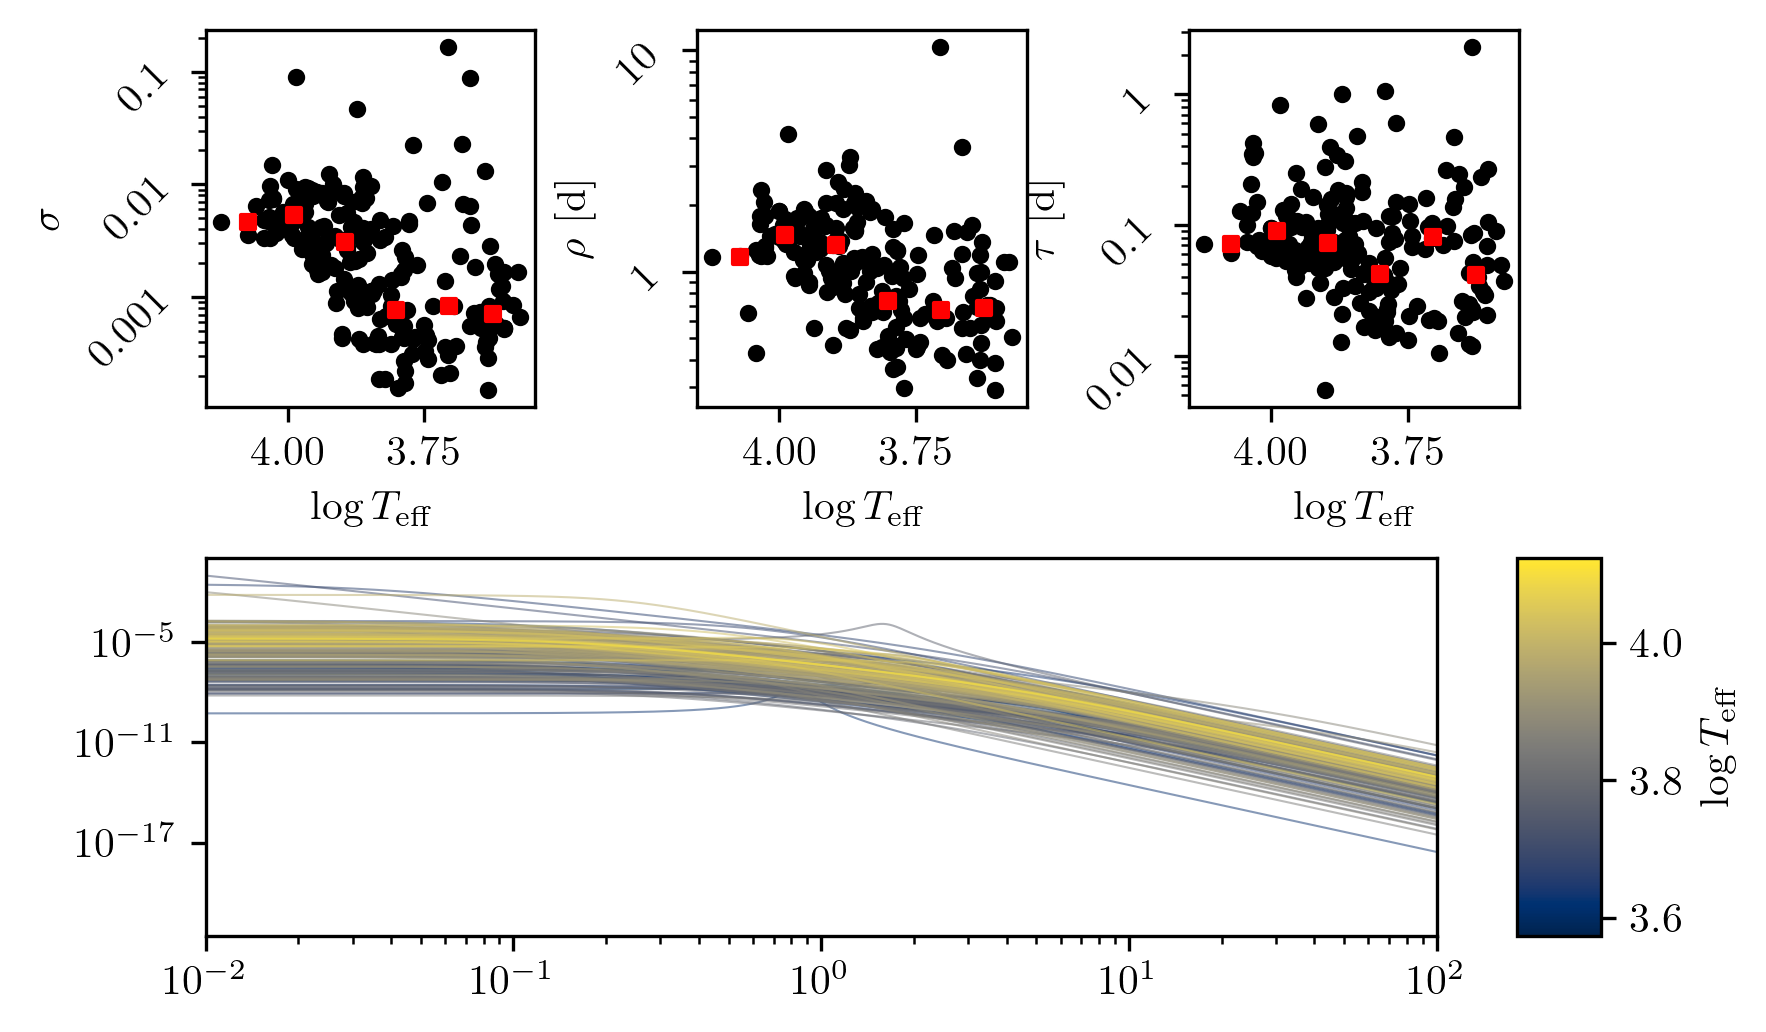

In [79]:
import celerite2
from celerite2 import terms

slf_gp = pd.read_csv('../OutputFiles/AppFig_GP_results.csv', index_col=0)
slf_gp_merge = pd.merge(cool_sgs,slf_gp,left_index=True,right_index=True)

mosaic = """
AAAAA.BBBBB.CCCCC.
DDDDDDDDDDDDDDDDEE
"""

temp_norm = colors.Normalize(vmin=slf_gp_merge['teff'].min(),vmax=slf_gp_merge['teff'].max())
cmap = plt.get_cmap('cividis')

freq = np.logspace(-2,3,1000)

fig, ax = plt.subplot_mosaic(mosaic, dpi=300)

ax['A'].scatter(slf_gp_merge['teff'], slf_gp_merge['Sigma'], c='k', s=10)
ax['B'].scatter(slf_gp_merge['teff'], slf_gp_merge['Rho'], c='k', s=10)
ax['C'].scatter(slf_gp_merge['teff'], slf_gp_merge['Tau'], c='k', s=10)

sgm_group = slf_gp_merge.groupby(np.around(10*slf_gp_merge['teff']))

ax['A'].scatter(sgm_group['teff'].median(), sgm_group['Sigma'].median(), c='r', marker='s', s=10)
ax['B'].scatter(sgm_group['teff'].median(), sgm_group['Rho'].median(), c='r', marker='s', s=10)
ax['C'].scatter(sgm_group['teff'].median(), sgm_group['Tau'].median(), c='r', marker='s', s=10)

for tic, row in slf_gp_merge.iterrows():
    kernel = terms.SHOTerm(sigma=row['Sigma'],rho=row['Rho'],tau=row['Tau'])
    
    psd = kernel.get_psd(2.0*np.pi*freq)
    
    ax['D'].loglog(freq, psd, c=cmap(temp_norm(row['teff'])),lw=0.5,alpha=0.5)
        
    
ax['D'].set(xlim=(1e-2,1e2))
plt.colorbar(cm.ScalarMappable(norm=temp_norm, cmap=cmap), ax=ax['D'], cax=ax['E'], label=r'$\log T_{\rm eff}$')
ax['A'].set(yscale='log',xlabel=r'$\log T_{\rm eff}$',ylabel=r'$\sigma$')
ax['A'].set_yticks([0.001,0.01,0.1])
ax['A'].set_yticklabels(labels=['0.001','0.01','0.1'],rotation=45)
ax['B'].set(yscale='log',xlabel=r'$\log T_{\rm eff}$',ylabel=r'$\rho$ [d]')
ax['B'].set_yticks([1,10])
ax['B'].set_yticklabels(labels=['1','10'],rotation=45)
ax['C'].set(yscale='log',xlabel=r'$\log T_{\rm eff}$',ylabel=r'$\tau$ [d]')
ax['C'].set_yticks([0.01,0.1,1])
ax['C'].set_yticklabels(labels=['0.01','0.1','1'],rotation=45)
ax['A'].invert_xaxis()
ax['B'].invert_xaxis()
ax['C'].invert_xaxis()
fig.subplots_adjust(wspace=50,hspace=0.4)

In [67]:
sgm_group['teff'].median()

teff
36.0    3.6240
37.0    3.7035
38.0    3.8010
39.0    3.8955
40.0    3.9890
41.0    4.0730
Name: teff, dtype: float64

In [14]:
slf_gp_merge

,RA,Dec,dist,pmRA,pmDec,Tmag,ContRatio,SpT,CommonName,MKType,...,w3mag,w4mag,RA_tic,Dec_tic,source_id,n_sectors,Tau,Rho,Sigma,LogJitter
179437520,79.971947,-68.067692,0.091019,1.593040,0.205590,9.8540,NaN,RSG,SV* HV 2450,M1,...,6.134,4.754,79.971929,-68.067717,4658722752228316160,12,0.037329,0.505469,0.000671,-7.995856
404965649,85.373961,-69.415872,0.060785,1.788260,0.708052,11.0373,NaN,RSG,CPD-69 502,NaN,...,7.247,5.391,85.374008,-69.415869,4657625263503324544,11,0.049189,1.111672,0.001679,-8.188039
40185978,76.968537,-70.434641,0.160504,2.140400,0.216068,11.1070,NaN,RSG,SK -70 80,M0,...,8.099,7.782,76.968487,-70.434600,4652070290243179776,12,0.090945,1.110829,0.000847,-12.169822
181445828,13.765720,-73.010260,0.236534,0.797799,-1.265550,11.0965,NaN,YSG,PMMR 74,G6Ia-Iab,...,8.492,8.396,NaN,NaN,4685961808462981248,1,0.268254,0.596741,0.000527,-10.779791
182735393,15.655494,-72.273615,0.085619,0.942084,-1.163470,11.1242,NaN,YSG,PMMR 135,G6.5Ia-Iab,...,8.588,8.536,NaN,NaN,4687498998758427520,1,0.104799,0.683443,0.000522,-10.206187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182730317,16.205624,-72.106040,0.055346,0.664882,-1.272430,11.4480,NaN,YSG,RMC 36,B3:Iak,...,11.061,9.228,NaN,NaN,4687507584364583040,1,0.100831,0.429997,0.003352,-8.374515
180792170,12.659946,-73.471738,0.058121,0.543531,-1.243180,11.1544,NaN,YSG,HD 5045,B2:I:,...,10.681,9.225,NaN,NaN,4685876050900042880,2,0.074079,1.255067,0.004819,-7.258806
182905190,16.484663,-72.329100,0.057287,0.986675,-1.257930,11.6057,NaN,YSG,LHA 115-S 45,B1.5Ia:,...,10.694,7.014,NaN,NaN,4687488965713758336,2,0.129394,0.653892,0.006460,-10.896078
180609595,12.262374,-73.361369,0.051217,0.833683,-1.258340,11.2247,NaN,YSG,HD 4862,B2I,...,11.226,9.238,NaN,NaN,4685926800243102848,2,0.061688,1.183635,0.003533,-10.849341
